In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
import re
from scipy import stats as stats
from scipy.stats import f as f_test
InteractiveShell.ast_node_interactivity = 'all'
import warnings
warnings.filterwarnings('ignore')

# Open the data file and study the general information

<div class="paragraph">You work as an analyst for "Megaline", a state mobile operator. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department would like to know which of the plans is more profitable in order to adjust the advertising budget. </div><div class="paragraph">You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 "Megaline" clients, specifically, who the clients are, where they are from, which plan they use, the number of calls made and SMS they sent in 2018. You have to analyse clients' behavior and work out the most profitable prepaid plan. </div><h3>Prepaid plans description</h3><div class="paragraph"><strong>Surf</strong></div>

<ol start="1"><li>Monthly charge: \$20</li><li>500 monthly minutes, 50 SMS and 15 GB of web traffic</li><li>After exceeding the package limits:
 1. 1 minute: 3 cents ("Megaline" always rounds up the minute and megabyte values. If the call lasted just one second, it will be counted as one minute);
 2. SMS: 3 cents;
 3. 1 GB of web traffic: \$10.</li></ol><div class="paragraph"><strong>Ultimate</strong></div><ol start="1"><li>Monthly charge: $70</li><li>3000 monthly minutes, 1000 SMS and 30 GB of web traffic</li><li>After exceeding the package limits:
 1. 1 minute: 1 cent;
 2. SMS: 1 cent;
 3. 1 GB of web traffic: \$7.</li></ol>


<div class="markdown markdown_size_normal markdown_type_theory"><h2><strong>Project description</strong></h2><h3>Data description</h3><div class="paragraph">The <code class="code-inline code-inline_theme_light">users</code> table (data on users):</div><ul><li><em>user_id</em> — unique user identifier</li><li><em>first_name</em> — user's name</li><li><em>last_name</em> — user's last name</li><li><em>age</em> — user's age (years)</li><li><em>reg_date</em> — subscription date (dd, mm, yy)</li><li><em>churn_date</em> — the date of use discontinue (if the value is missed, the calling plan was used at the moment of data extraction)</li><li><em>city</em> — user's city of residence</li><li><em>tarif</em> — calling plan name</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">calls</code> table (data on calls):</div><ul><li><em>id</em> — unique call identifier</li><li><em>call_date</em> — call date</li><li><em>duration</em> — call duration in minutes</li><li><em>user_id</em> — the identifier of the user making a call</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">messages</code> table (data on SMS):</div><ul><li><em>id</em> — unique SMS identifier</li><li><em>message_date</em> — SMS date</li><li><em>user_id</em> — the identifier of the user sending an SMS</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">internet</code> table (data on web sessions):</div><ul><li><em>id</em> — unique session id</li><li><em>mb_used</em> —  the volume of web traffic spent during a session (in megabytes)</li><li><em>session_date</em> — web session date</li><li><em>user_id</em> — user identifier</li></ul><div class="paragraph">The <code class="code-inline code-inline_theme_light">tariffs</code> table (data on the plans):</div><ul><li><em>tariff_name</em> — calling plan name</li><li><em>rub_monthly_fee</em> — monthly charge in rubles</li><li><em>minutes_included</em> — monthly minutes within package limits</li><li><em>messages_included</em> — monthly SMS within package limits</li><li><em>mb_per_month_included</em> — web traffic volume within package limits (in megabytes)</li><li><em>rub_per_minute</em> — the price per minute after exceeding the package limits (e.g., if the package included 100 minutes, the 101st minute will be charged)</li><li><em>rub_per_message</em> — the price per SMS after exceeding the package limits</li><li><em>rub_per_gb</em> — the price per extra gigabyte of web traffic after exceeding the package limits (1 GB = 1024 megabytes)</li></ul></div>

In [0]:
host="https://code.s3.yandex.net/"

In [0]:
megaline_calls = pd.read_csv(host+"datasets/megaline_calls.csv")
megaline_internet = pd.read_csv(host+"datasets/megaline_internet.csv")
megaline_messages = pd.read_csv(host+"datasets/megaline_messages.csv")
megaline_tariffs = pd.read_csv(host+"datasets/megaline_tariffs.csv")
megaline_users = pd.read_csv(host+"datasets/megaline_users.csv")

In [0]:
megaline_datasets = {"megaline_calls":megaline_calls, "megaline_internet":megaline_internet, "megaline_messages":megaline_messages, "megaline_tariffs":megaline_tariffs, "megaline_users":megaline_users}

In [11]:
for name, ds in megaline_datasets.items():
    f"{name} {ds.shape}"

'megaline_calls (137735, 4)'

'megaline_internet (104825, 4)'

'megaline_messages (76051, 3)'

'megaline_tariffs (2, 8)'

'megaline_users (500, 8)'

In [12]:
for name, ds in megaline_datasets.items():
    f"{name}"
    ds.info()

'megaline_calls'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


'megaline_internet'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


'megaline_messages'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


'megaline_tariffs'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   tariff_name            2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


'megaline_users'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   tariff      500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


# Prepare the data

<ul><li>Convert the data to the necessary types;</li><li>Find and remove the errors in the data.</li></ul><div class="paragraph">Explain what errors did you find and how did you remove them. 
Please note: quite a lot of calls have a duration of 0.0 minutes, a strong hint that there is a problem with the data and needs preprocessing. </div><div class="paragraph">For each user, find:</div><ul><li>the number of calls made and minutes spent per month;</li><li>the number of SMS sent per month;</li><li>the volume of web traffic per month;</li><li>the monthly profit from each of the users (subtract free package limit from the total number of calls, SMS and web traffic; multiply the result by the calling plan value; add monthly charge depending on the calling plan).</li></ul>

In [22]:
for name, ds in megaline_datasets.items():
    f"{name}"
    ds.sample(2)

'megaline_calls'

,id,user_id,call_date,duration
128668,1462_81,1462,2018-11-08,2.65
123766,1436_744,1436,2018-10-06,0.00


'megaline_internet'

,id,user_id,session_date,mb_used
31728,1144_469,1144,2018-05-24,475.61
78963,1368_132,1368,2018-09-02,97.99


'megaline_messages'

,id,user_id,message_date
13165,1088_93,1088,2018-11-03
32644,1203_289,1203,2018-04-07


'megaline_tariffs'

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,tariff_name
1,1000,30720,3000,70,7,0.01,0.01,ultimate
0,50,15360,500,20,10,0.03,0.03,surf


'megaline_users'

,user_id,first_name,last_name,age,city,reg_date,tariff,churn_date
86,1086,Adena,Macias,36,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-01-13,ultimate,NaN
271,1271,Darrin,Rose,48,"New York-Newark-Jersey City, NY-NJ-PA MSA",2018-06-24,surf,NaN


In [0]:
megaline_calls["call_date"] = pd.to_datetime(megaline_calls["call_date"], format='%Y-%m-%d')

In [0]:
megaline_internet["session_date"] = pd.to_datetime(megaline_internet["session_date"], format='%Y-%m-%d')

In [0]:
megaline_messages["message_date"] = pd.to_datetime(megaline_messages["message_date"], format='%Y-%m-%d')

In [0]:
megaline_users["reg_date"] = pd.to_datetime(megaline_users["reg_date"], format='%Y-%m-%d')

In [0]:
megaline_users["churn_date"] = pd.to_datetime(megaline_users["churn_date"], format='%Y-%m-%d')

In [0]:
def missing_values(df):
  df_nulls=pd.concat([df.dtypes, df.isna().sum(), df.isna().sum()/len(df)], axis=1)
  df_nulls.columns = ["type","count","missing_ratio"]
  df_nulls=df_nulls[df_nulls["count"]>0]
  df_nulls.sort_values(by="missing_ratio", ascending=False)
  return df_nulls

In [16]:
for name, ds in megaline_datasets.items():
  print(name)
  missing_values(ds)

megaline_calls


,type,count,missing_ratio


megaline_internet


,type,count,missing_ratio


megaline_messages


,type,count,missing_ratio


megaline_tariffs


,type,count,missing_ratio


megaline_users


,type,count,missing_ratio
churn_date,object,466,0.932


churn_date — the date of use discontinue (if the value is missed, the calling plan was used at the moment of data extraction)


In [36]:
megaline_users.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'tariff', 'churn_date'],
      dtype='object')

In [0]:
megaline_users.loc[megaline_users["churn_date"].isna(), "churn_date"] = pd.datetime.now().date()

In [0]:
megaline_users["churn_date"] = pd.to_datetime(megaline_users["churn_date"], format='%Y-%m-%d')

In [0]:
megaline_users["used_days"] = (megaline_users["churn_date"]-megaline_users["reg_date"]).dt.days

In [0]:
megaline_users = megaline_users.drop(["churn_date"], axis=1)

In [0]:
def describe_full(df):
    data_describe = df.describe().T
    df_numeric=df._get_numeric_data()
    dtype_df=df_numeric.dtypes
    data_describe['dtypes']=dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %']=data_null
    Cardinality=df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality']=Cardinality
    df_skew=df_numeric.skew(axis = 0, skipna = True) 
    data_describe['Skew']=df_skew
    return data_describe

In [20]:
for name, ds in megaline_datasets.items():
  print(name)
  describe_full(ds)

megaline_calls


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,137735.0,1247.658046,139.416268,1000.0,1128.00,1247.00,1365.00,1499.0,int64,0.0,481,0.010325
duration,137735.0,6.745927,5.839241,0.0,1.29,5.98,10.69,37.6,float64,0.0,2802,0.693502


megaline_internet


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,104825.0,1242.496361,142.053913,1000.0,1122.00,1236.00,1367.00,1499.00,int64,0.0,489,0.080268
mb_used,104825.0,366.713701,277.170542,0.0,136.08,343.98,554.61,1693.47,float64,0.0,57624,0.532269


megaline_messages


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,76051.0,1245.972768,139.843635,1000.0,1123.0,1251.0,1362.0,1497.0,int64,0.0,402,0.042754


megaline_tariffs


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
messages_included,2.0,525.00,671.751442,50.00,287.500,525.00,762.500,1000.00,int64,0.0,2,NaN
mb_per_month_included,2.0,23040.00,10861.160159,15360.00,19200.000,23040.00,26880.000,30720.00,int64,0.0,2,NaN
minutes_included,2.0,1750.00,1767.766953,500.00,1125.000,1750.00,2375.000,3000.00,int64,0.0,2,NaN
usd_monthly_pay,2.0,45.00,35.355339,20.00,32.500,45.00,57.500,70.00,int64,0.0,2,NaN
usd_per_gb,2.0,8.50,2.121320,7.00,7.750,8.50,9.250,10.00,int64,0.0,2,NaN
usd_per_message,2.0,0.02,0.014142,0.01,0.015,0.02,0.025,0.03,float64,0.0,2,NaN
usd_per_minute,2.0,0.02,0.014142,0.01,0.015,0.02,0.025,0.03,float64,0.0,2,NaN


megaline_users


,count,mean,std,min,25%,50%,75%,max,dtypes,Missing %,Cardinality,Skew
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0,int64,0.0,500,0.000000
age,500.0,45.486,16.972269,18.0,30.00,46.0,61.00,75.0,int64,0.0,58,0.040081


We have denormalized table, let's build table that could neatly fit for ours purpose

In [0]:
megaline_users_messages = megaline_users.merge(megaline_messages).rename({"message_id":"id"}, axis=1)

In [0]:
megaline_users_internet = megaline_users.merge(megaline_internet).rename({"session_id":"id"}, axis=1)

In [0]:
megaline_users_call = megaline_users.merge(megaline_calls).rename({"call_id":"id"}, axis=1)

In [0]:
megaline_users_messages['message_month'] = megaline_users_messages['message_date'].dt.month

In [0]:
megaline_users_internet['session_month'] = megaline_users_internet['session_date'].dt.month

In [0]:
megaline_users_call['call_month'] = megaline_users_call['call_date'].dt.month

In [76]:
megaline_users_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104825 entries, 0 to 104824
Data columns (total 12 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        104825 non-null  int64         
 1   first_name     104825 non-null  object        
 2   last_name      104825 non-null  object        
 3   age            104825 non-null  int64         
 4   city           104825 non-null  object        
 5   reg_date       104825 non-null  datetime64[ns]
 6   tariff         104825 non-null  object        
 7   used_days      104825 non-null  int64         
 8   id             104825 non-null  object        
 9   session_date   104825 non-null  datetime64[ns]
 10  mb_used        104825 non-null  float64       
 11  session_month  104825 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 10.4+ MB


In [79]:
len(megaline_users_internet["id"].unique()) == len(megaline_users_internet["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_internet["id"] = megaline_users_internet["id"].str.replace("_", "").astype(int)

In [0]:
map_tariff = {'ultimate':0, 'surf':1}

In [0]:
megaline_users_internet.tariff = (megaline_users_internet.tariff == 'surf').astype(int)

In [89]:
megaline_users_call.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137735 entries, 0 to 137734
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     137735 non-null  int64         
 1   first_name  137735 non-null  object        
 2   last_name   137735 non-null  object        
 3   age         137735 non-null  int64         
 4   city        137735 non-null  object        
 5   reg_date    137735 non-null  datetime64[ns]
 6   tariff      137735 non-null  object        
 7   used_days   137735 non-null  int64         
 8   id          137735 non-null  object        
 9   call_date   137735 non-null  datetime64[ns]
 10  duration    137735 non-null  float64       
 11  call_month  137735 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(4), object(5)
memory usage: 13.7+ MB


In [90]:
len(megaline_users_call["id"].unique()) == len(megaline_users_call["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_call["id"] = megaline_users_call["id"].str.replace("_", "").astype(int)

In [0]:
megaline_users_call.tariff = (megaline_users_call.tariff == 'surf').astype(int)

In [94]:
megaline_users_messages.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76051 entries, 0 to 76050
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   user_id        76051 non-null  int64         
 1   first_name     76051 non-null  object        
 2   last_name      76051 non-null  object        
 3   age            76051 non-null  int64         
 4   city           76051 non-null  object        
 5   reg_date       76051 non-null  datetime64[ns]
 6   tariff         76051 non-null  object        
 7   used_days      76051 non-null  int64         
 8   id             76051 non-null  object        
 9   message_date   76051 non-null  datetime64[ns]
 10  message_month  76051 non-null  int64         
dtypes: datetime64[ns](2), int64(4), object(5)
memory usage: 7.0+ MB


In [95]:
len(megaline_users_messages["id"].unique()) == len(megaline_users_messages["id"].str.replace("_", "").astype(int).unique())

True

In [0]:
megaline_users_messages["id"] = megaline_users_messages["id"].str.replace("_", "").astype(int)

In [0]:
megaline_users_messages.tariff = (megaline_users_messages.tariff == 'surf').astype(int)

In [0]:
megaline_users.tariff = (megaline_users.tariff == 'surf').astype(int)

In [0]:
megaline_datasets = {"megaline_users_messages":megaline_users_messages, "megaline_users_call":megaline_users_call, "megaline_users_internet":megaline_users_internet}

In [99]:
for name, ds in megaline_datasets.items():
  print(name)
  print(ds.duplicated().sum())

megaline_users_messages
0
megaline_users_call
0
megaline_users_internet
0


In [153]:
megaline_users_call_pivot = pd.DataFrame(megaline_users_call.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=['count', 'sum'])).reset_index(drop=False)
megaline_users_call_pivot.columns = ['user_id', 'call_month', 'count_calls', 'total_duration']
megaline_users_call_pivot.sample(2)

,user_id,call_month,count_calls,total_duration
1319,1291,5,79,529.04
335,1072,9,82,544.75


In [152]:
megaline_users_messages_pivot = pd.DataFrame(megaline_users_messages.pivot_table(index=['user_id', 'message_month'], values='id', aggfunc=['count'])).reset_index(drop=False)
megaline_users_messages_pivot.columns = ['user_id', 'msg_month', 'count_msg']
megaline_users_messages_pivot.sample(2)

,user_id,msg_month,count_msg
645,1174,10,79
788,1211,8,64


In [149]:
megaline_users_internet_pivot = pd.DataFrame(megaline_users_internet.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum')).reset_index(drop=False)
megaline_users_internet_pivot.columns = ['user_id', 'session_month', 'total_mb']
megaline_users_internet_pivot.sample(2)

,user_id,session_month,total_mb
945,1196,8,30549.10
350,1075,9,10018.48


In [0]:
megaline_agg_df = (megaline_users
  .join(megaline_users_call_pivot.groupby('user_id')[['total_duration', 'count_calls']].sum(), on='user_id')
  .join(megaline_users_internet_pivot.groupby('user_id')['total_mb'].sum(), on='user_id')
  .join(megaline_users_messages_pivot.groupby('user_id')['count_msg'].sum(), on='user_id'))

In [0]:
#kx+b=y, 500 when tariff is 1 and  3000 when is 0, we have -2500x+3000
megaline_agg_df['duration_left'] = megaline_agg_df["total_duration"] - (-2500*megaline_agg_df["tariff"] + 3000)

In [0]:
def calc_call_profit(r):
    duration = r['duration_left']
    tariff = 0.03 if r['tariff'] else 0.01
    return duration*tariff

In [0]:
megaline_agg_df['profit_call'] = megaline_agg_df.apply(calc_call_profit, axis=1)

In [0]:
megaline_agg_df['mb_left'] = megaline_agg_df["total_mb"] - (-15*1024*megaline_agg_df["tariff"]+30*1024)

In [0]:
def calc_internet_profit(r):
    internet = r['total_mb']/1024
    tariff = 10 if r['tariff'] else 7
    return internet*tariff

In [0]:
megaline_agg_df['profit_internet'] = megaline_agg_df.apply(calc_internet_profit, axis=1)

In [0]:
megaline_agg_df['msg_left'] = megaline_agg_df["count_msg"] - (-950*megaline_agg_df["tariff"] + 1000)

In [0]:
def calc_msg_profit(r):
    msg = r['msg_left']
    tariff = 0.03 if r['tariff'] else 0.01
    return msg*tariff

In [0]:
megaline_agg_df['profit_msg'] = megaline_agg_df.apply(calc_msg_profit, axis=1)

In [0]:
months = 12

In [0]:
megaline_agg_df['profit_total'] = (megaline_agg_df['profit_internet'] + megaline_agg_df['profit_call'] + megaline_agg_df['profit_msg']) +(-50*megaline_agg_df["tariff"]+70)

In [0]:
megaline_agg_df['duration_per_month'] = megaline_agg_df['total_duration'] / months
megaline_agg_df['calls_month'] = megaline_agg_df['count_calls'] / months
megaline_agg_df['internet_mb_per_month'] = megaline_agg_df['total_mb'] / months
megaline_agg_df['msg_per_month'] = megaline_agg_df['count_msg'] / months

In [0]:
megaline_agg_df['profit_per_month'] = megaline_agg_df['profit_total'] / months

### Summary

We had really low missed data, - only churn_date, but it's logically correct, cause on the extraction date users still use services. created new feature - used days, - count of days
in duration of that users used to services and column churn_date was dropped. Also datetimes columns was converted to demanded format. 
Also features were created for representing the month usage of services.

# Analyse the data

<div class="paragraph">Describe the clients' behavior. For the users of each of the plans, find the number of minutes and SMS and the volume of web traffic they require per month. Calculate the mean, variance and standard deviation. Plot histograms. Describe the distributions. </div>

In [0]:
metrics = {'calls_month':'call per month usage', 'internet_mb_per_month':'internet per month usage, mb', 'msg_per_month':'messages per month usage'}

In [0]:
def generate_plots(df, metrics=metrics):
   ultimate = df[df["tariff"]==0]
   surf = df[df["tariff"]==1]
   for col, title in metrics.items():
     plt.hist(ultimate[col], alpha=0.5, label=f'ultimate {col}')
     plt.hist(surf[col], alpha=0.5, label=f'surf {col}')
     plt.legend(loc='upper right')
     plt.show()

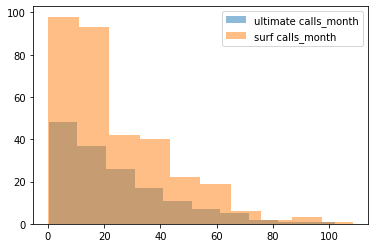

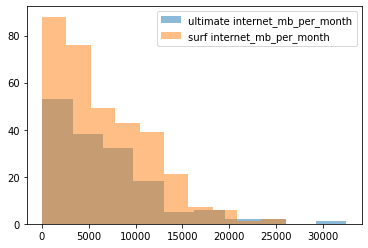

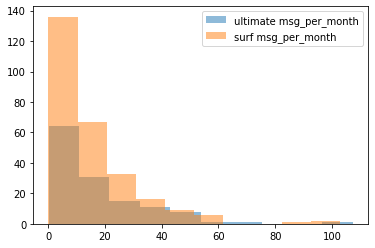

In [233]:
generate_plots(megaline_agg_df)

In [0]:
def generate_report(df, tariff_repr, metrics=metrics):
   print(f"{tariff_repr}") 
   tariff = 0 if tariff_repr == "ultimate" else 1
   dfq = df[df["tariff"]==tariff]
   funcs = {'average':np.mean, 'variance':np.var, 'std':np.std}
   for col, title in metrics.items():
     for method_name, func in funcs.items():
         print(f'{method_name} {title}: {func(dfq[col]):.2f}')


### Summary

In [194]:
generate_report(megaline_agg_df, 'ultimate')

ultimate
average call per month usage: 23.47
variance call per month usage: 392.62
std call per month usage: 19.81
average internet per month usage, mb: 6578.87
variance internet per month usage, mb: 30559701.79
std internet per month usage, mb: 5528.08
average messages per month usage: 17.07
variance messages per month usage: 279.27
std messages per month usage: 16.71


In [195]:
generate_report(megaline_agg_df, 'surf')

surf
average call per month usage: 24.05
variance call per month usage: 393.28
std call per month usage: 19.83
average internet per month usage, mb: 6537.70
variance internet per month usage, mb: 24710213.62
std internet per month usage, mb: 4970.94
average messages per month usage: 15.13
variance messages per month usage: 243.26
std messages per month usage: 15.60


# Test the hypotheses

<ul><li>the average profit from the users of Ultimate and Surf calling plans is different;</li><li>the average profit from the users in NY-NJ area is different from that of the users from other regions.</li></ul><div class="paragraph">Assign the threshold <em>alpha</em> value independently. </div><div class="paragraph">Explain:</div><ul><li>how you formulated the null and alternative hypotheses;</li><li>what criterion you used for testing the hypotheses and why.</li></ul>

##### Hypotheses is avg profit of two plans are not different (the null hypothesis that Var(X) == Var(Y))
We will use F-test



In [239]:
megaline_agg_df.columns

Index(['user_id', 'first_name', 'last_name', 'age', 'city', 'reg_date',
       'tariff', 'used_days', 'total_duration', 'count_calls', 'total_mb',
       'count_msg', 'duration_left', 'profit_call', 'mb_left',
       'profit_internet', 'msg_left', 'profit_msg', 'duration_per_month',
       'calls_month', 'internet_mb_per_month', 'msg_per_month', 'profit_total',
       'profit_per_month'],
      dtype='object')

In [0]:
ultimate = megaline_agg_df[megaline_agg_df["tariff"] == 0]['profit_per_month'].dropna()
surf = megaline_agg_df[megaline_agg_df["tariff"] == 1]['profit_per_month'].dropna()

In [0]:
def check_f_test(X,Y):
  F = np.var(X) / np.var(Y)
  p_value = f_test.cdf(F, len(X)-1, len(Y)-1)
  return p_value > .05

In [270]:
if check_f_test(ultimate, surf):
    print('could not reject the null hypothesis, therefore that Var(ultimate) == Var(surf)')
else:
    print('There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)')

There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)


In [272]:
results = stats.ttest_ind(ultimate, surf, equal_var=True)
print(results.pvalue)
if results.pvalue < .05:
      print('reject the null hypothesis, therefore the average profits for plans are different')
else:
      print('Fail in rejecting of the null hypothesis, therefore the average profits for plans are the same')

0.00015199606573599
reject the null hypothesis, therefore the average profits for plans are different


In [253]:
megaline_agg_df["city"].unique()
# "NY-NJ"

array(['Atlanta-Sandy Springs-Roswell, GA MSA',
       'Seattle-Tacoma-Bellevue, WA MSA',
       'Las Vegas-Henderson-Paradise, NV MSA', 'Tulsa, OK MSA',
       'Dallas-Fort Worth-Arlington, TX MSA',
       'San Francisco-Oakland-Berkeley, CA MSA',
       'Grand Rapids-Kentwood, MI MSA',
       'Orlando-Kissimmee-Sanford, FL MSA',
       'San Jose-Sunnyvale-Santa Clara, CA MSA',
       'Cleveland-Elyria, OH MSA',
       'Chicago-Naperville-Elgin, IL-IN-WI MSA', 'Knoxville, TN MSA',
       'New York-Newark-Jersey City, NY-NJ-PA MSA', 'Pittsburgh, PA MSA',
       'Fresno, CA MSA',
       'Washington-Arlington-Alexandria, DC-VA-MD-WV MSA',
       'Indianapolis-Carmel-Anderson, IN MSA', 'Jacksonville, FL MSA',
       'Los Angeles-Long Beach-Anaheim, CA MSA',
       'Omaha-Council Bluffs, NE-IA MSA',
       'Houston-The Woodlands-Sugar Land, TX MSA',
       'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD MSA',
       'Tampa-St. Petersburg-Clearwater, FL MSA',
       'Birmingham-Hoover, AL MSA'

In [0]:
megaline_agg_df["is_NY"] = megaline_agg_df["city"].str.contains("NY-NJ")

In [0]:
NY = megaline_agg_df[megaline_agg_df["is_NY"]]['profit_per_month'].dropna()
not_NY = NY = megaline_agg_df[~megaline_agg_df["is_NY"]]['profit_per_month'].dropna()

In [259]:
if check_f_test(NY, not_NY):
    print('could not reject the null hypothesis, therefore that Var(ultimate) == Var(surf)')
else:
    print('There is significance to reject the null hypothesis, therefore Var(ultimate) != Var(surf)')   

could not reject the null hypothesis, therefore that Var(ultimate) == Var(surf)


In [262]:
results = stats.ttest_ind(NY, not_NY, equal_var=True)
if results.pvalue < .05:
      print('reject the null hypothesis, therefore the average profits for plans are different')
else:
      print('Fail in rejecting of the null hypothesis, therefore the average profits for plans are the same')

Fail in rejecting of the null hypothesis, therefore the average profits for plans are the same


# Write an overall conclusion

<div class="paragraph"><strong>Format:</strong> Complete the task in <em>Jupyter Notebook</em>. Insert the programming code in <em>code</em> cells and text explanations in <em>markdown</em> cells then apply formatting and headings.</div>

In [0]:
We checked ultimate and surf plans
Checked data, some statistics, also dists for some total features were checked
Also were checked  null hypotesis: average profit of the ultimate plan and the surf plan is the same, (significance level is 0.05)
The same check we did for NY-NJ clients and other regions
